In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99

In [2]:
os.chdir('..')  # change to root directory

In [3]:
# Load data
import pickle
from firenet.util import add_uncertainty_features
with open('./data/d_data.pkl', 'rb') as infile:
    d_data = pickle.load(infile)
    
d_data = add_uncertainty_features(d_data)
d_data.keys()

dict_keys(['fullbay', 'fullbayerr', 'shortbay', 'shortbayerr', 'redshift', 'observed', 'observederr', 'obserr_to_short', 'obs_to_short'])

# Single train/test split

In [4]:
from firenet.ml import RegUncPredictor

pred = RegUncPredictor(d_data)
pred.preprocess()
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8752        0.6712     +  0.0751
      2        0.5768        0.3935     +  0.0875
      3        0.3913        0.3257     +  0.0869
      4        0.3369        0.2845     +  0.0880
      5        0.3090        0.2638     +  0.0847
      6        0.2873        0.2496     +  0.0851
      7        0.2706        0.2386     +  0.0788
      8        0.2578        0.2300     +  0.1118
      9        0.2475        0.2228     +  0.0995
     10        0.2391        0.2171     +  0.0814
     11        0.2319        0.2120     +  0.0902
     12        0.2256        0.2080     +  0.0681
     13        0.2199        0.2049     +  0.0727
     14        0.2150        0.2024     +  0.0774
     15        0.2106        0.2003     +  0.0767
     16        0.2065        0.1986     +  0.0759
     17        0.2028        0.1971     +  0.0822
     18        0.1996        0.1958     +  0.0802


In [5]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      313.3290       73.8520     +  0.1296
      2     -254.7472     -648.8933     +  0.1005
      3    -1139.7797    -1500.9908     +  0.0980
      4    -1952.6871    -2081.4747     +  0.1172
      5    -2464.5263    -2396.6403     +  0.0881
      6    -2752.4977    -2560.7280     +  0.1292
      7    -2915.1661    -2648.5552     +  0.0719
      8    -3011.9995    -2698.6603     +  0.0987
      9    -3074.2287    -2729.5791     +  0.1081
     10    -3117.2766    -2749.8247     +  0.1248
     11    -3148.7736    -2763.9027     +  0.0760
     12    -3172.6325    -2773.9058     +  0.0727
     13    -3190.9592    -2781.2553     +  0.0758
     14    -3205.2596    -2786.8473     +  0.0737
     15    -3216.7073    -2791.2217     +  0.0746
     16    -3226.1320    -2794.9273     +  0.0759
     17    -3234.1256    -2798.3066     +  0.0766
     18    -3241.0154    -2801.3620     +  0.0709


In [6]:
pred.reg.test()

PACS_70      0.218260
PACS_100     0.191469
PACS_160     0.173414
SPIRE_250    0.185114
SPIRE_350    0.200334
SPIRE_500    0.214310
Name: rmse, dtype: float64

In [7]:
pred.unc.test()

PACS_70      1.055272
PACS_100     1.108588
PACS_160     1.208961
SPIRE_250    1.089232
SPIRE_350    1.023933
SPIRE_500    0.994720
Name: mean_chisq, dtype: float64

In [8]:
y_t, y_p, y_perr = pred.get_target_set()

In [9]:
# Storing and loading models
# from firenet.ml import ModelStore

# ModelStore().store(pred, name='nnet')  # Save to './models/nnet.pkl' by default
# pred = ModelStore().load(d_data, name='nnet')  # Load "nnet" model

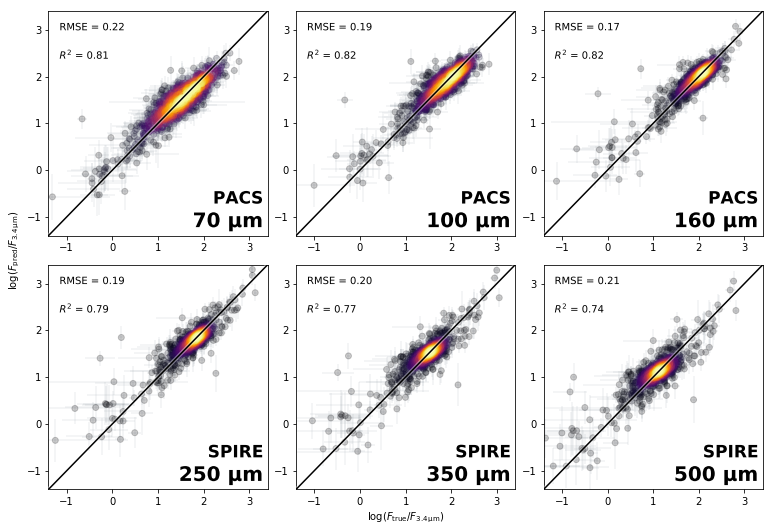

In [10]:
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Full set predictor
Using a 4-fold train/test split, training 4 predictors. Each galaxy is used as a test sample once.

In [11]:
from firenet.ml.fullsetpredictor import FullSetPredictor
fspred = FullSetPredictor(d_data)

In [12]:
fspred.prepare_splits(shuffle_state=123)

In [13]:
fspred.train()

Start training model 1/4...
Start training model 2/4...
Start training model 3/4...
Start training model 4/4...


In [14]:
# Storing and loading models
# from firenet.ml.modelstore import ModelStore

# ModelStore().store(fspred, name='fsnnet')  # Save to './models/fsnnet.pkl' by default
# fspred = ModelStore().load(d_data, name='fsnnet')  # Load "fsnnet" model

In [15]:
y_t, y_p, y_perr = fspred.get_combined_test()

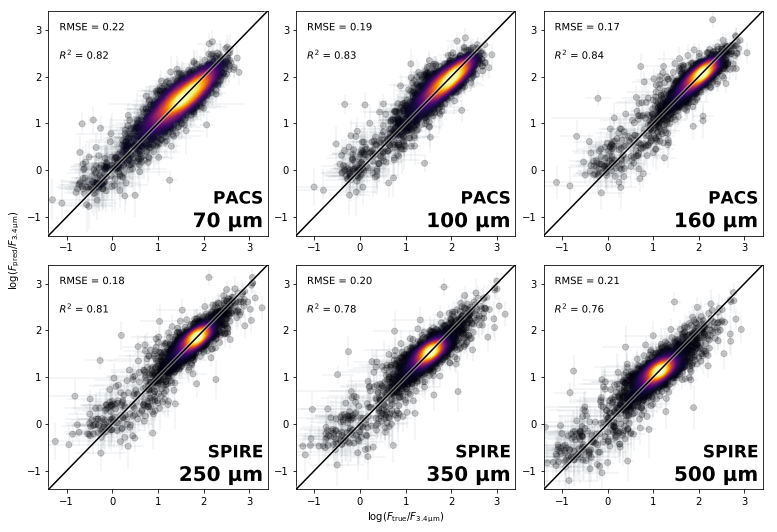

In [16]:
# See paper Fig. 3
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Use all (DustPedia + H-ATLAS) data into single model
This model can then be used for other data sets (see notebook `04_predicting.ipynb`)

In [17]:
# Use all data for training and testing (no longer unbiased test set)
idx_tot = d_data['fullbay'].index.values.copy()
np.random.seed(123)
np.random.shuffle(idx_tot)
pred = RegUncPredictor(d_data)
pred.preprocess(idx_train=idx_tot, idx_test=idx_tot)
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.7882        0.5118     +  0.0984
      2        0.4379        0.3321     +  0.0988
      3        0.3485        0.3019     +  0.0940
      4        0.3225        0.2850     +  0.0934
      5        0.3032        0.2703     +  0.0950
      6        0.2868        0.2591     +  0.1835
      7        0.2726        0.2499     +  0.1148
      8        0.2611        0.2430     +  0.1084
      9        0.2525        0.2375     +  0.0899
     10        0.2457        0.2334     +  0.0979
     11        0.2403        0.2299     +  0.0918
     12        0.2358        0.2271     +  0.0915
     13        0.2318        0.2238     +  0.0897
     14        0.2283        0.2207     +  0.0910
     15        0.2250        0.2175     +  0.0961
     16        0.2220        0.2137     +  0.0937
     17        0.2187        0.2109     +  0.0933
     18        0.2160        0.2078     +  0.0944


In [18]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      243.0562     -106.4027     +  0.1200
      2     -646.7032    -1268.8473     +  0.1008
      3    -1828.0494    -2154.9756     +  0.1004
      4    -2527.2691    -2536.9697     +  0.0951
      5    -2826.8179    -2685.8429     +  0.0972
      6    -2954.9312    -2753.2275     +  0.1068
      7    -3019.6931    -2791.9428     +  0.1022
      8    -3059.4041    -2817.2525     +  0.1011
      9    -3086.9265    -2834.6661     +  0.0957
     10    -3107.3336    -2847.2882     +  0.0945
     11    -3123.2371    -2857.1242     +  0.0979
     12    -3136.0263    -2865.3026     +  0.0938
     13    -3146.6214    -2872.5512     +  0.0950
     14    -3155.5494    -2878.8792     +  0.1004
     15    -3163.4479    -2884.4436     +  0.0964
     16    -3170.2819    -2889.1628     +  0.0956
     17    -3176.1572    -2893.1781     +  0.0993
     18    -3181.2677    -2896.5506     +  0.0978


In [19]:
pred.reg.test(tset='train')

PACS_70      0.205549
PACS_100     0.176100
PACS_160     0.151044
SPIRE_250    0.161366
SPIRE_350    0.177310
SPIRE_500    0.192000
Name: rmse, dtype: float64

In [20]:
# Store all data model
# ModelStore().store(pred, name='nnet_alldata')